# Dependencies

First, we want to import some of the dependencies.

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "2,3"

import numpy as np
import pandas as pd
import pickle

#Import torch stuff.
import torch
import torch.nn as nn
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

#pip install git+https://github.com/facebookresearch/WavAugment.git
import augment

import IPython.display as ipd
import matplotlib.pyplot as plt

from tqdm import trange, tqdm

#Append the path outside so we can load bom1.
import sys
sys.path.append('..')

import bom1.wakeword as wf
import bom1.bom1 as bom1
from   bom1.toolbox import WakewordDataset

from sklearn.metrics import accuracy_score

In [2]:
#Set the notebook to run on the GPU, if available.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'This notebook is running on the {device.type}.')

if device.type == 'cuda':
    torch.cuda.current_device()
    torch.cuda.set_device(1)

    #Set the batch size on cuda
    batch_size = 128

else:
    batch_size = 8

This notebook is running on the cpu.


# Defining Dataset and Dataloader

First, let us get the datasets and dataloaders in order.

In [3]:
#Create the datasets.
train_dataset = WakewordDataset(folder='/work3/s164419/01005WakeWordData/1_to_5_1s_train/train/', f = T.Spectrogram(hop_length=40), 
                                normalize=True, #normalize the audio when reading it with torchaudio. 
                                transforms = [#wf.AudioAugment(reverb = 100, snr = 15, pitch = 150, p = [0.5, 0.5, 0.5]),
                                              wf.TransformMono(), 
                                              wf.Padder(22050)],

                                n = 500,
                               )

val_dataset = WakewordDataset(folder='/work3/s164419/01005WakeWordData/every50_1s_val_test/val/', f = T.Spectrogram(hop_length=40), 
                                normalize=True, #normalize the audio when reading it with torchaudio. 
                                transforms = [#wf.AudioAugment(reverb = 100, snr = 15, pitch = 150, p = [0.5, 0.5, 0.5]),
                                              wf.TransformMono(), 
                                              wf.Padder(22050)],
                               )

test_dataset = WakewordDataset(folder='/work3/s164419/01005WakeWordData/every50_1s_val_test/test/', f = T.Spectrogram(hop_length=40), 
                                normalize=True, #normalize the audio when reading it with torchaudio. 
                                transforms = [#wf.AudioAugment(reverb = 100, snr = 15, pitch = 150, p = [0.5, 0.5, 0.5]),
                                              wf.TransformMono(), 
                                              wf.Padder(22050)],
                               )

train_loader  = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
val_loader    = DataLoader(val_dataset  , shuffle=True, batch_size=batch_size)
test_loader   = DataLoader(test_dataset , shuffle=True, batch_size=batch_size)

# CNN with default spectrogram

Let us make a completely vanilla CNN where `x` is the default spectrogram. 

In [4]:
x, target, path = next(iter(train_loader))

In [5]:
from bom1.models import CNN_V1

cnn = CNN_V1()

#Make sure that our spectrogram and our CNN match.
assert cnn(x).shape == torch.Size([batch_size, 2]), 'Output should be [batch_size x 2]'

## Training on GPU and Loading the Model

In [7]:
path = '/work3/s164419/01005WakeWordData/models/CNN_V1/'

if device.type == 'cuda':
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters())

    #First, let us just train the model to make sure it works.
    nepoch = 50
    wf.train_cnn(cnn, criterion, optimizer, train_loader, val_loader, device, nepoch, path = path) 

    #Stop the GPU here.
    raise NotImplementedError('Stop the GPU here.')
else:
    # open a file, where you stored the pickled data
    file = open(os.path.join(path, 'statistics.p'), 'rb')

    # dump information to that file
    train_statistics, val_statistics = pickle.load(file)

    # close the file
    file.close()

    train_avg_batch_loss = []

    for item in train_statistics:
        train_avg_batch_loss.append(train_statistics[item]['avg_batch_loss'])

    val_avg_batch_loss = []

    for item in val_statistics:
        val_avg_batch_loss.append(val_statistics[item]['avg_batch_loss'])

# Evaluate the Model on a Lecture

In [16]:
# open a file, where you stored the pickled data
file = open('/work3/s164419/01005WakeWordData/results/CNN_1_to_5_1s_hoplength40_val_performance.p', 'rb')

# dump information to that file
data = pickle.load(file)

# close the file
file.close()

#ID, p, t1s, t2s = data

#p = np.array(p)
#t = np.vstack((np.array(t1s), np.array(t2s))).mean(axis=0)

#Sort them according to time.
#p = p[t.argsort()]
#t = t[t.argsort()]

In [51]:
ID, p, t1, t2 = data

#Easier to work with np arrays.
ID = np.array(ID)
p  = np.array(p)
t1 = np.array(t1)
t2 = np.array(t2)

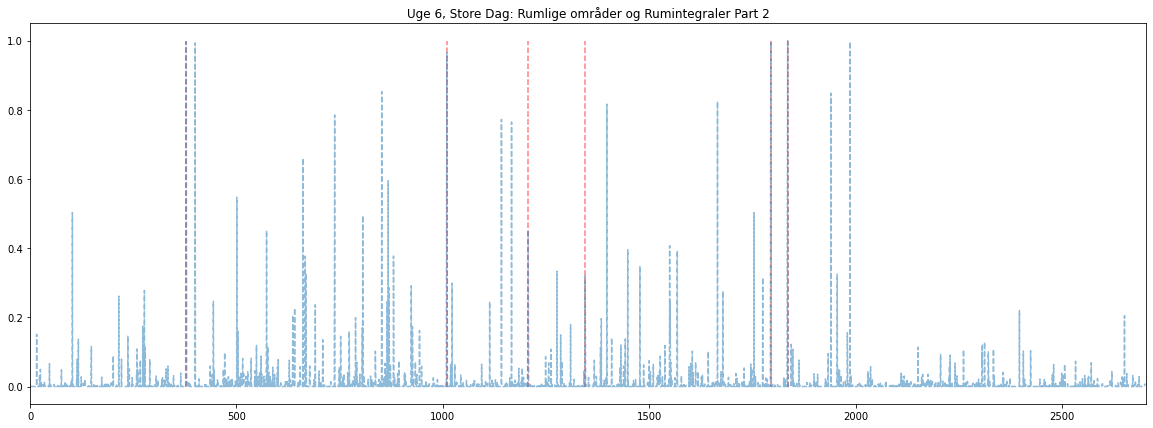

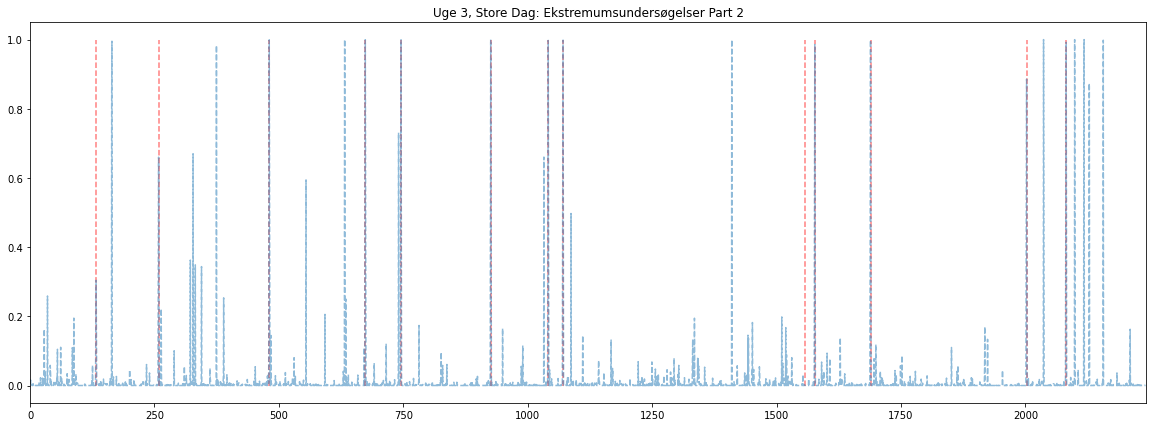

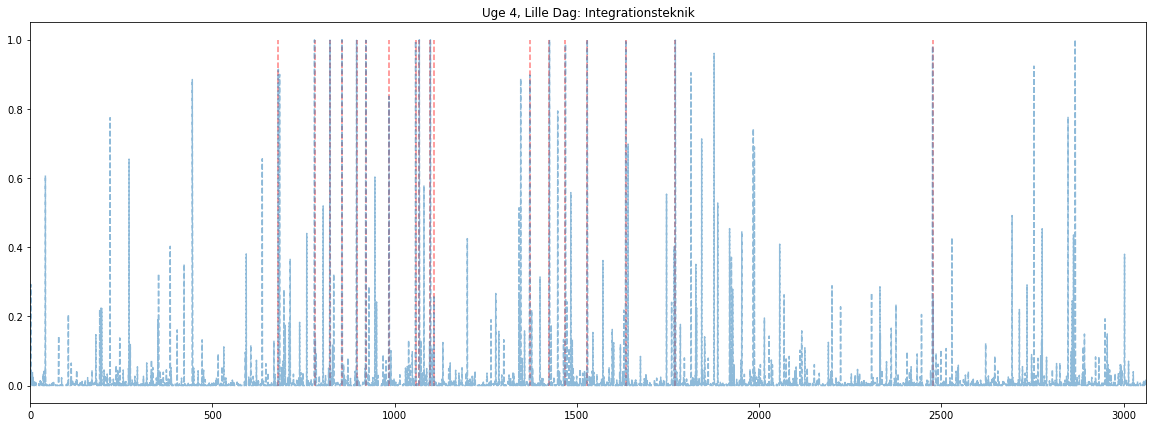

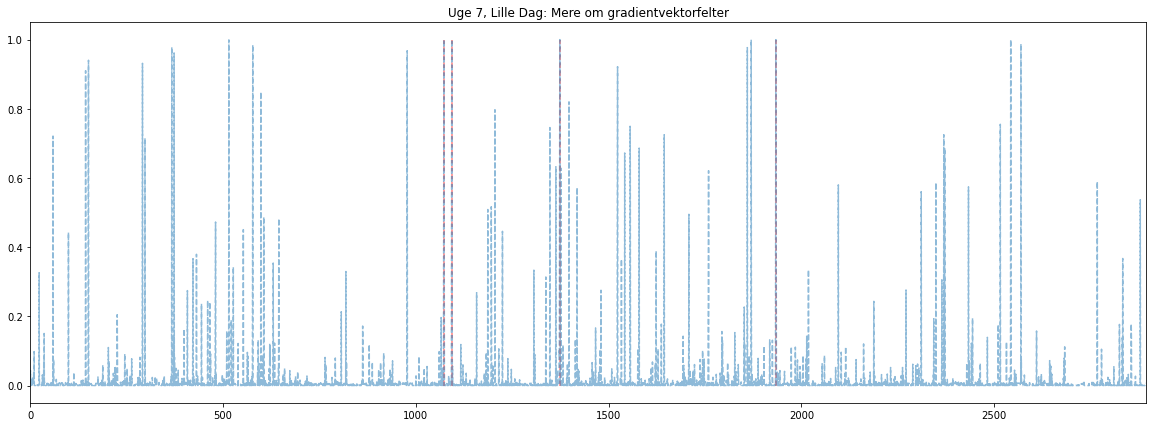

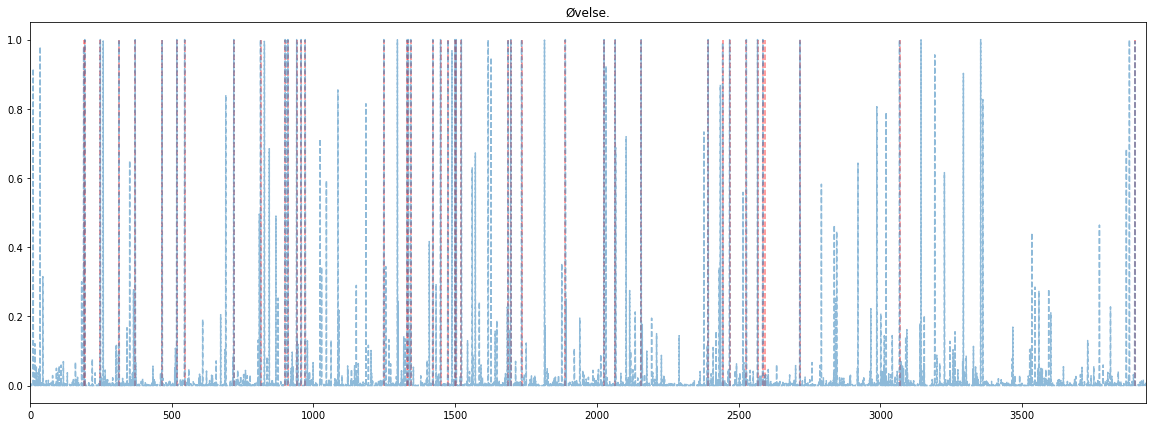

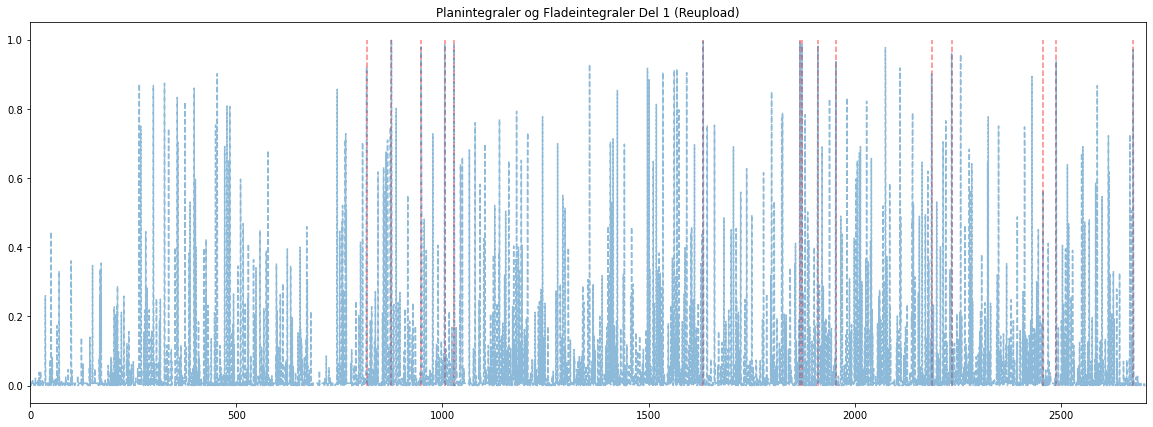

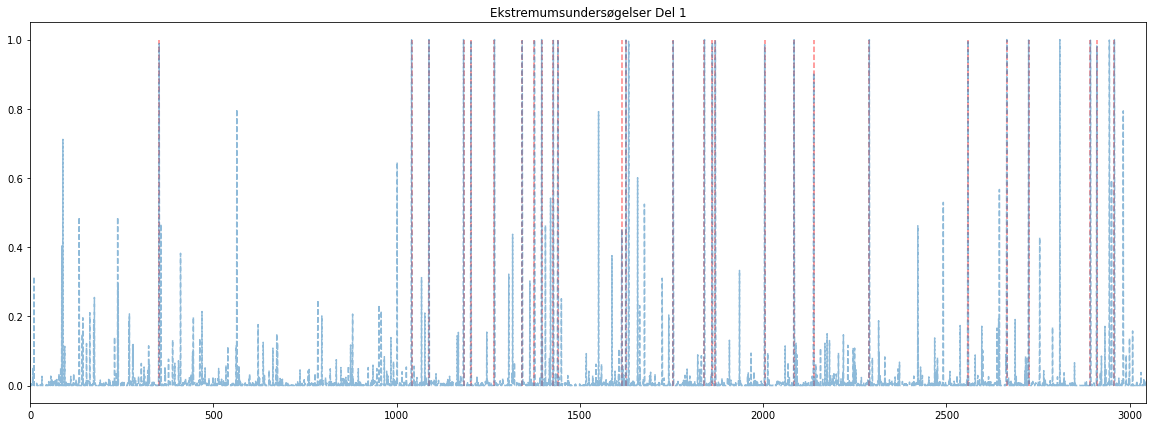

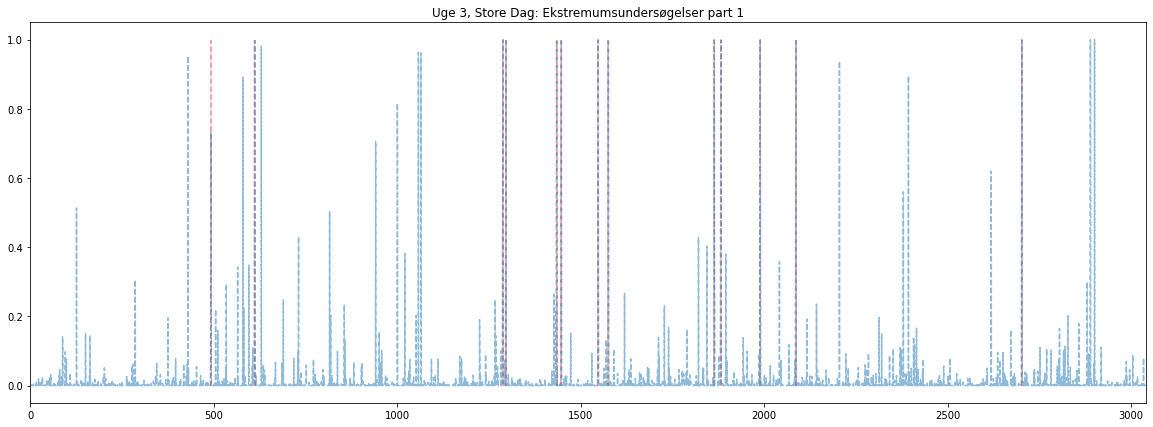

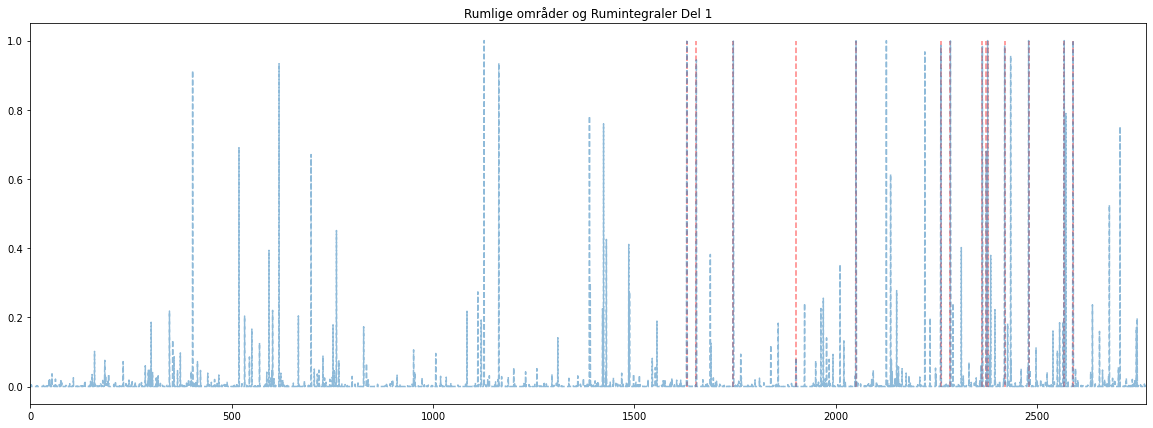

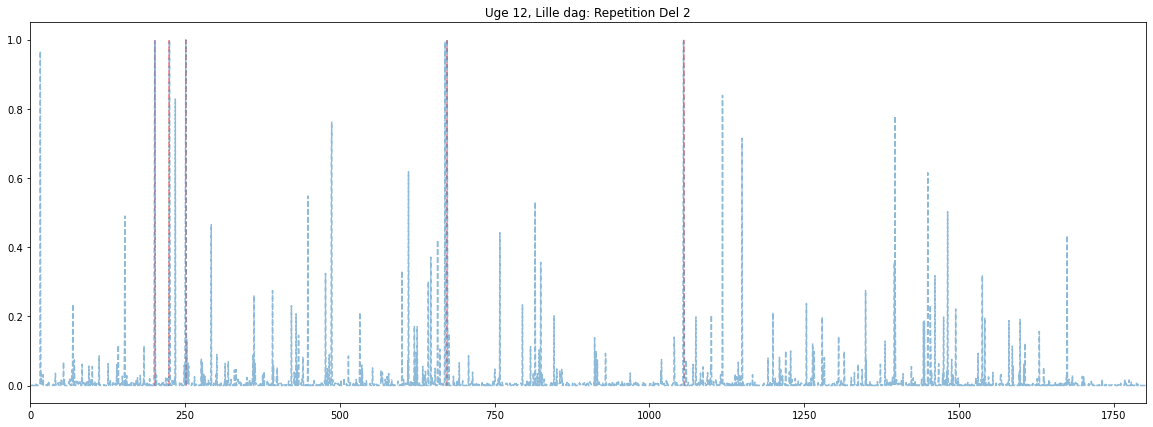

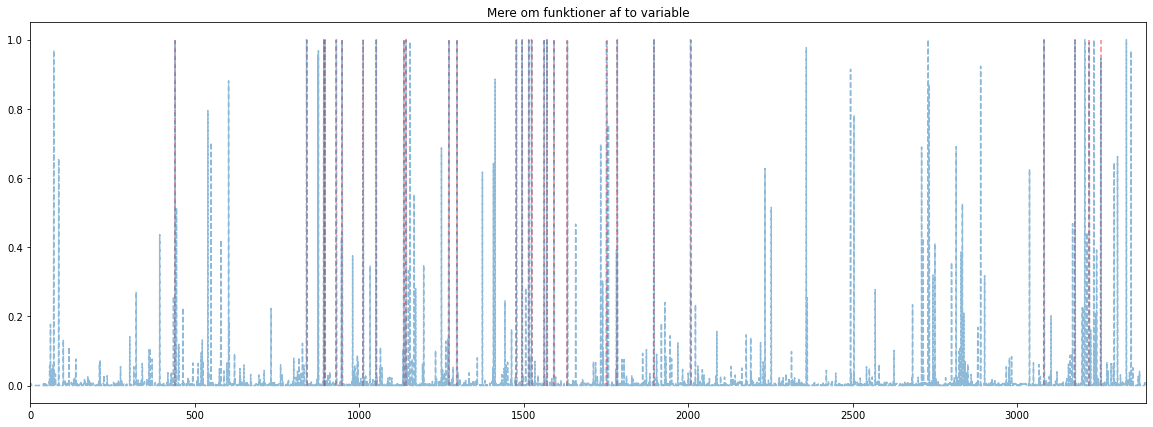

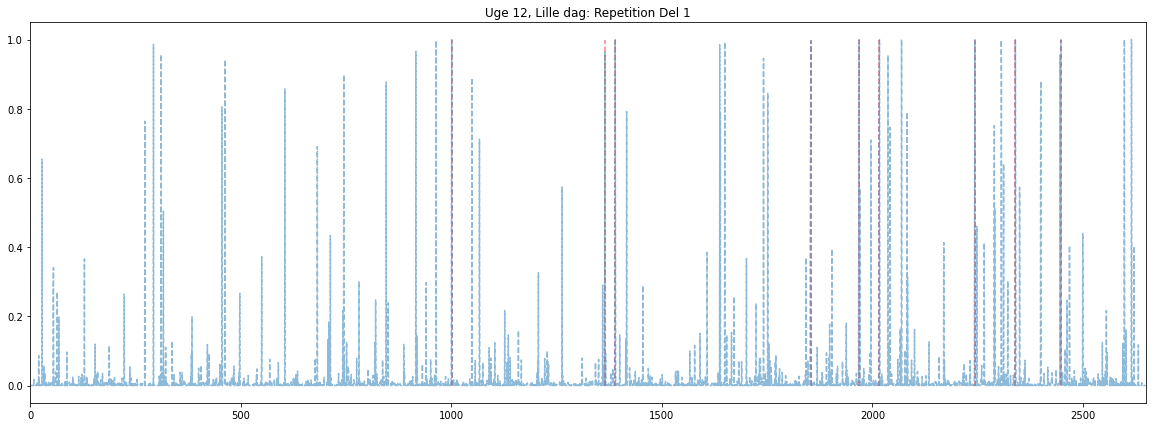

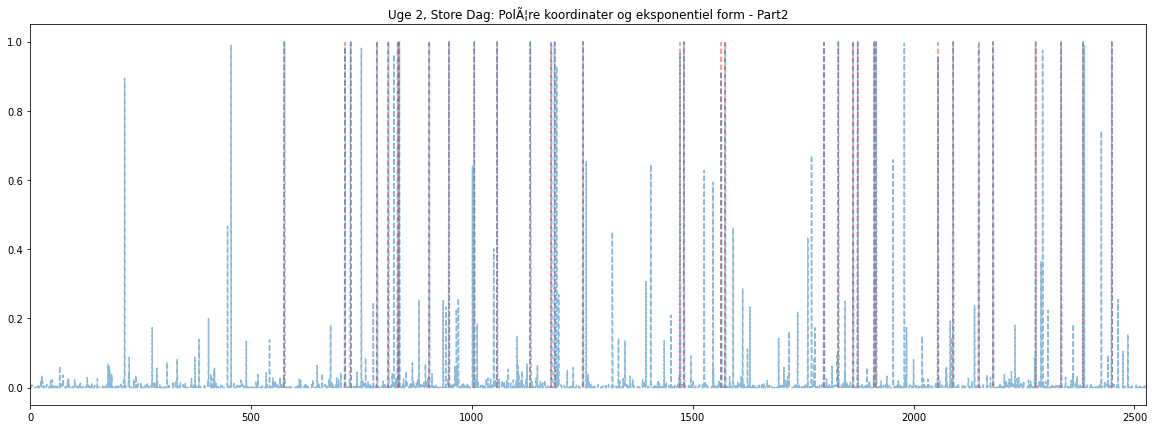

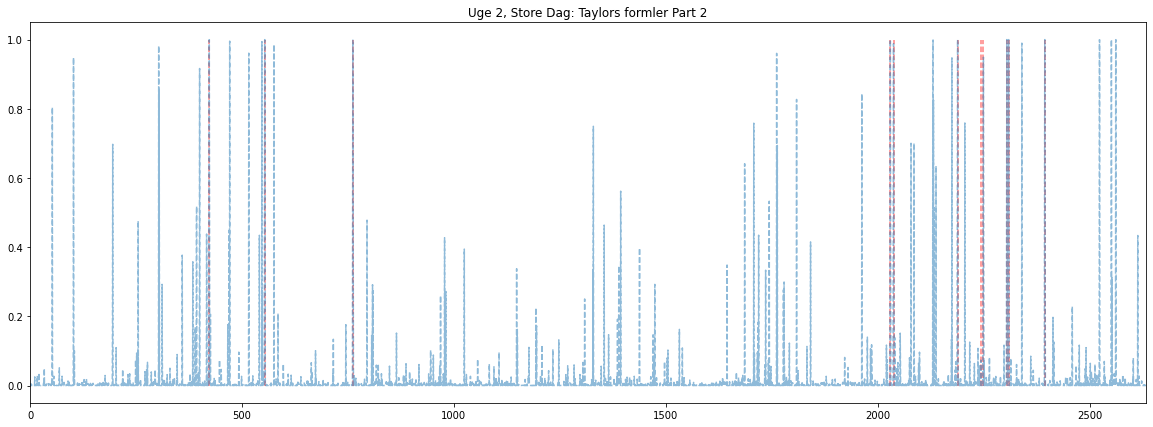

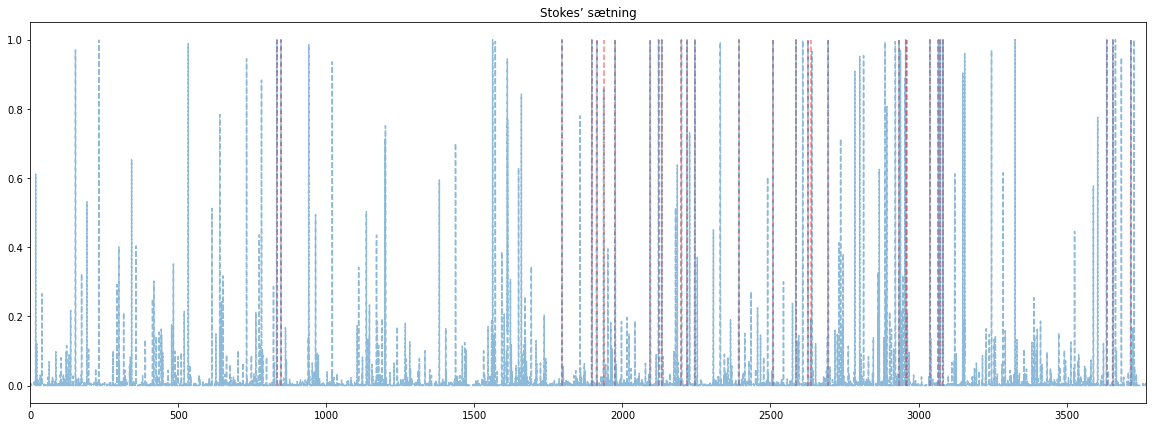

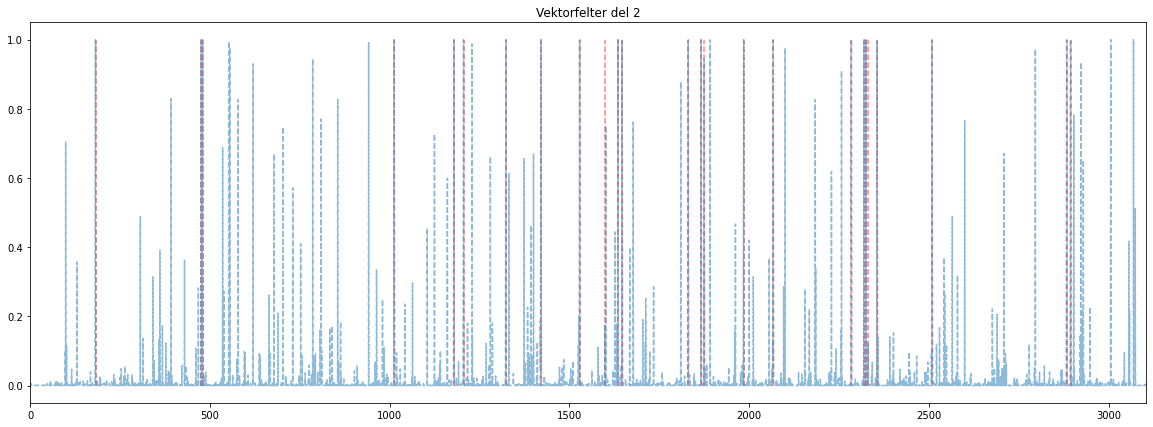

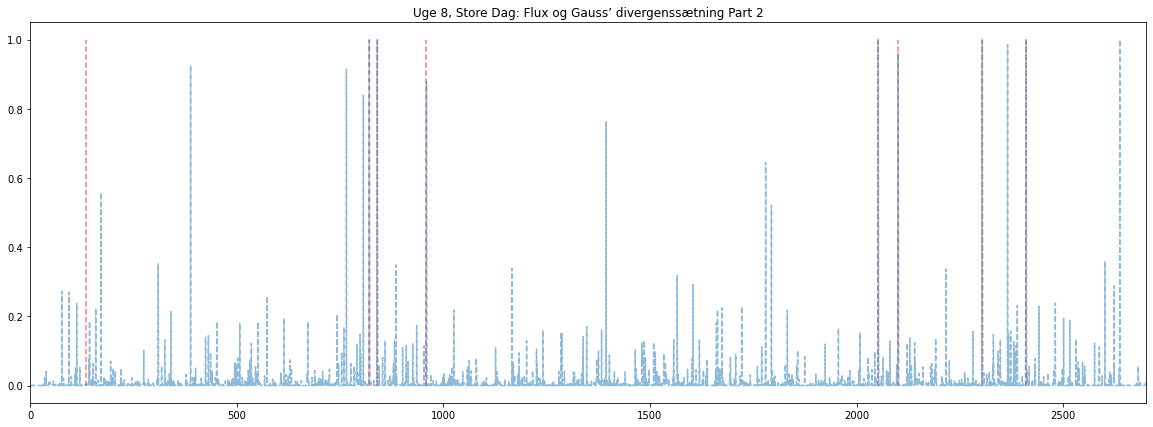

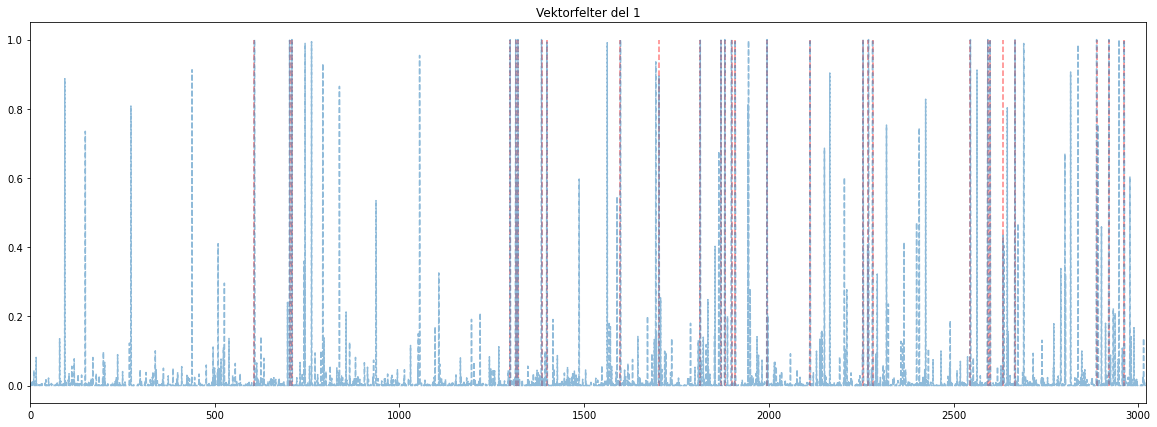

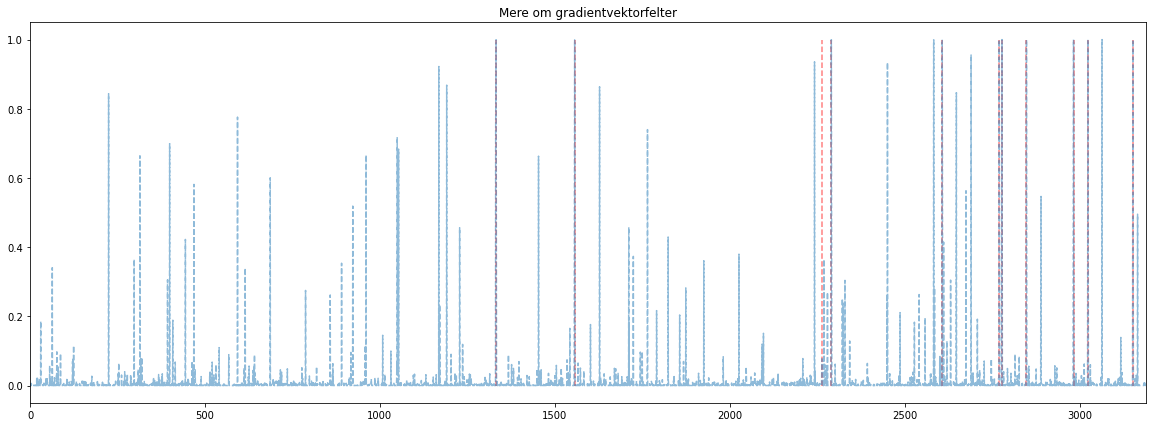

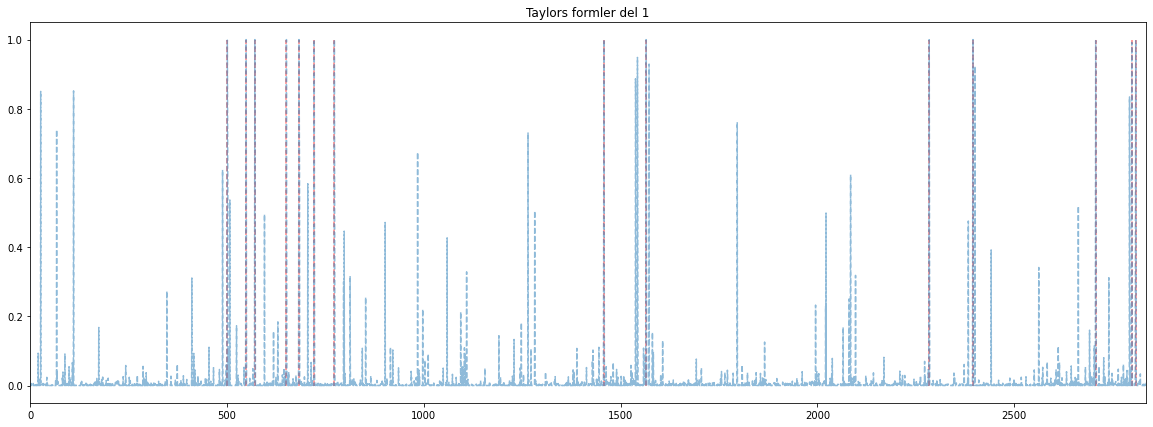

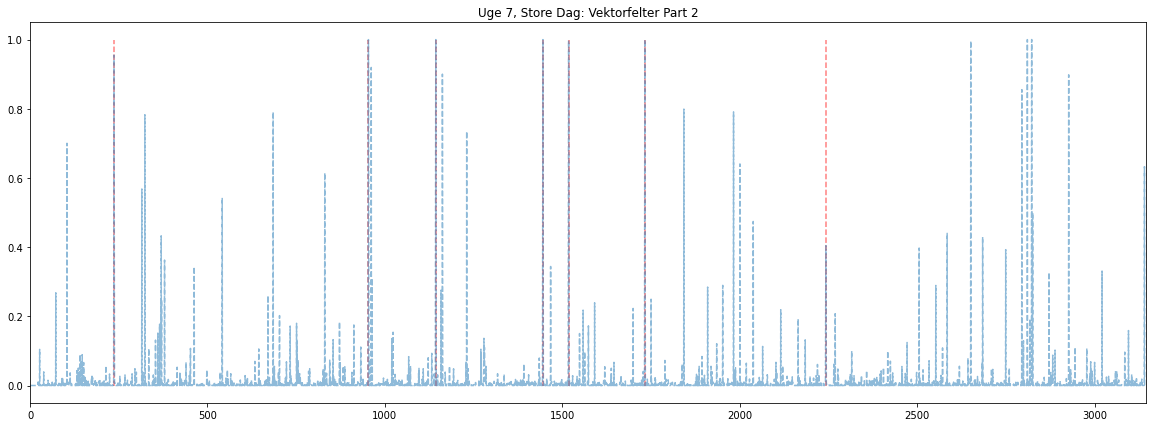

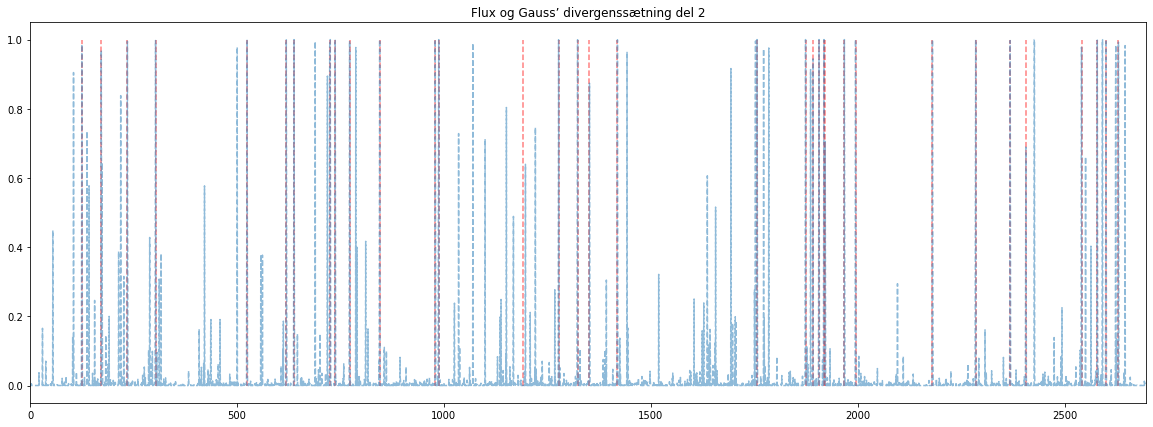

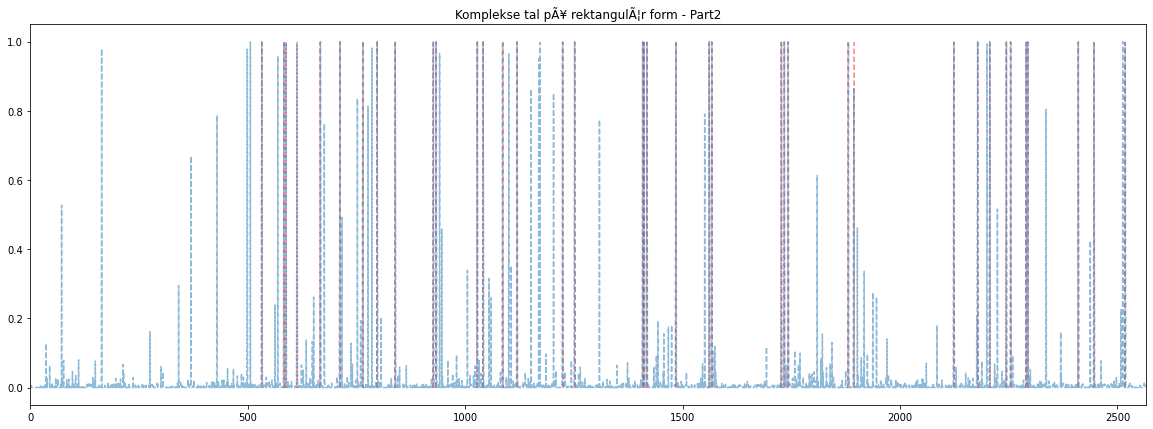

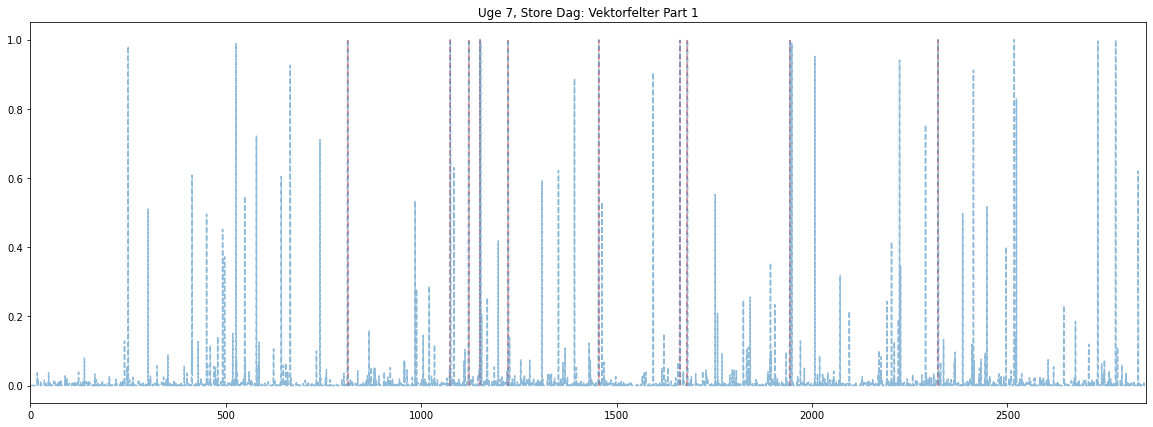

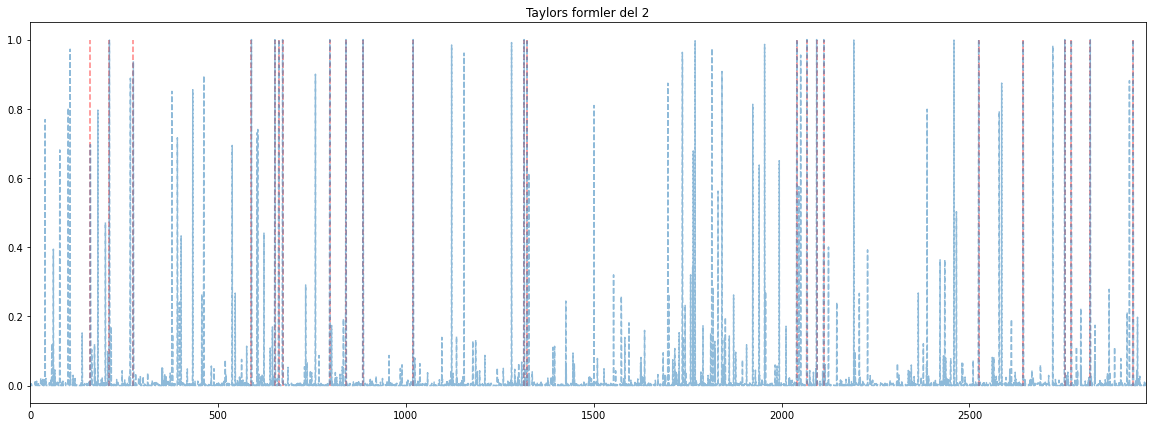

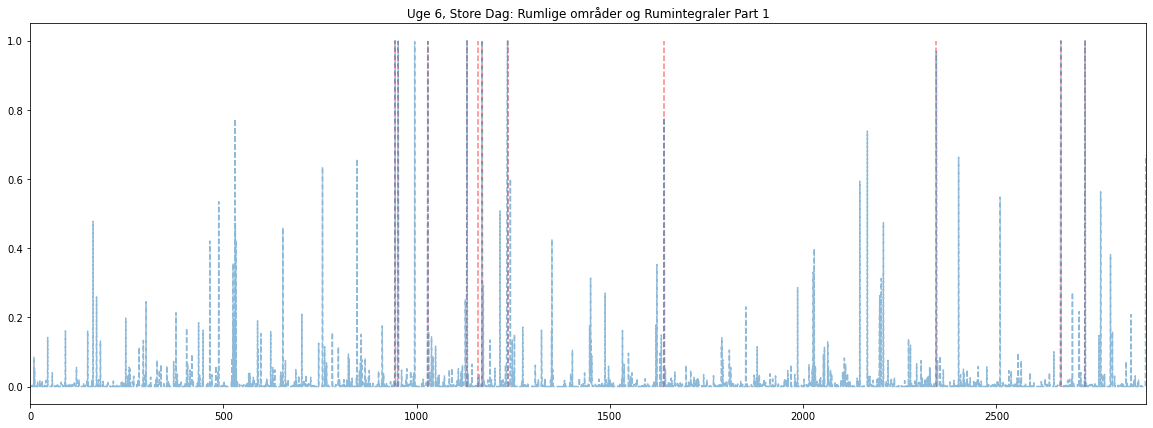

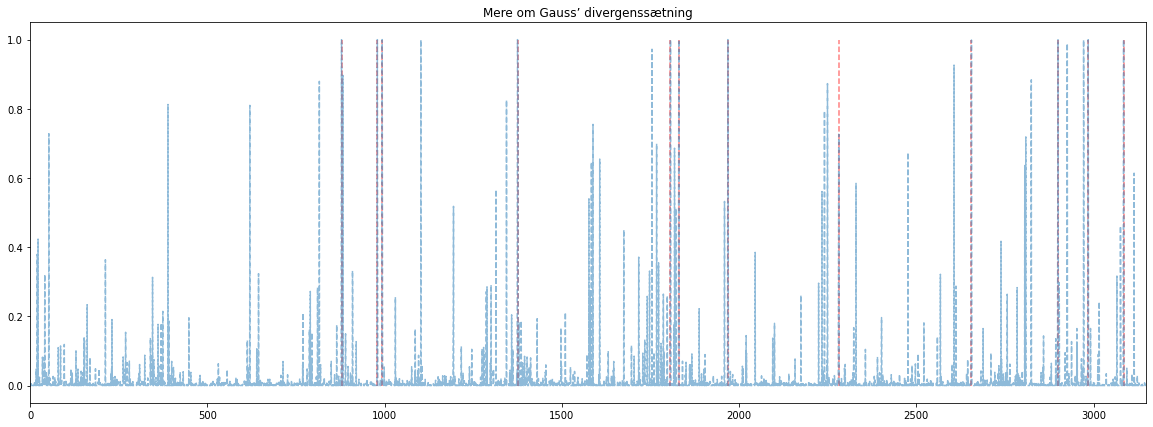

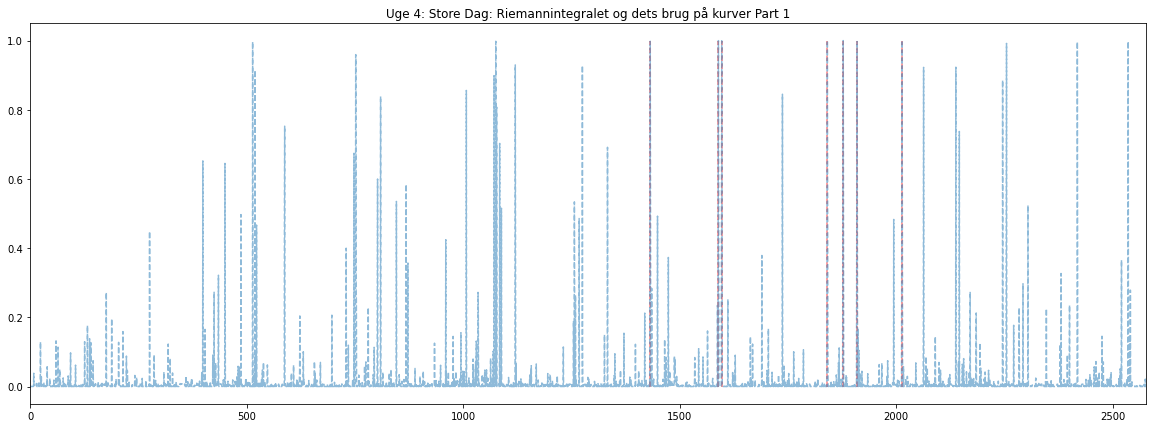

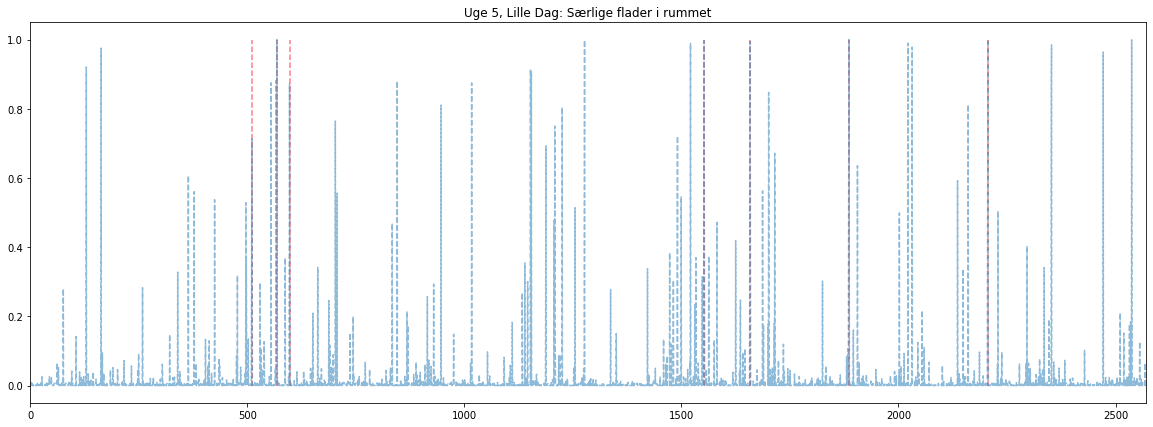

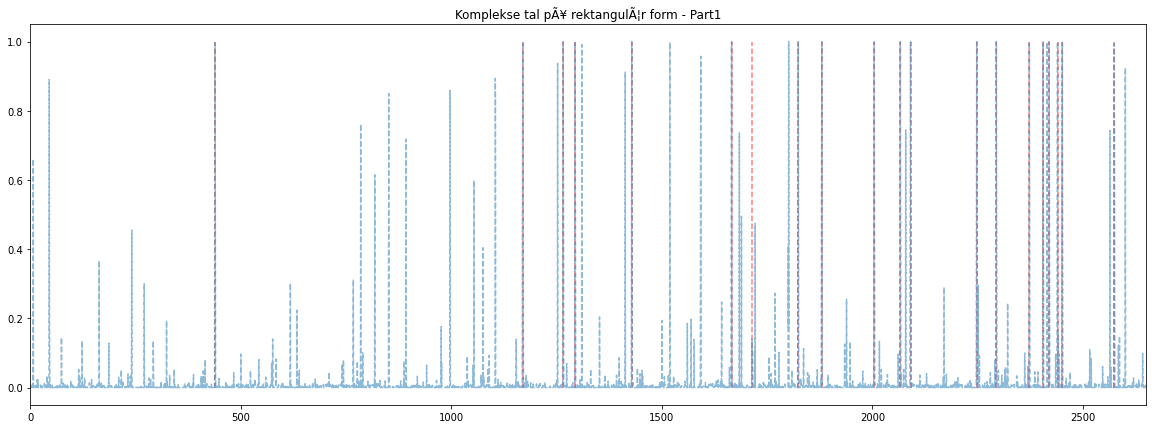

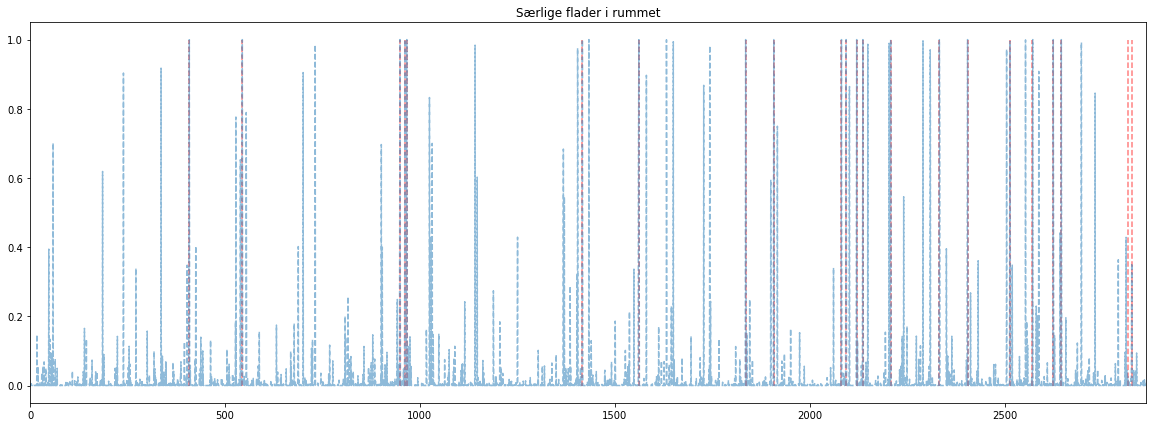

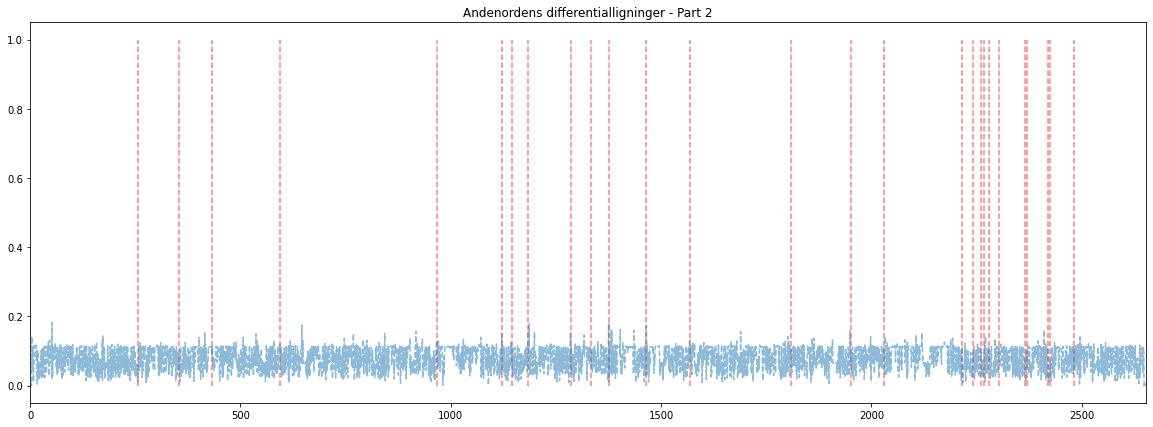

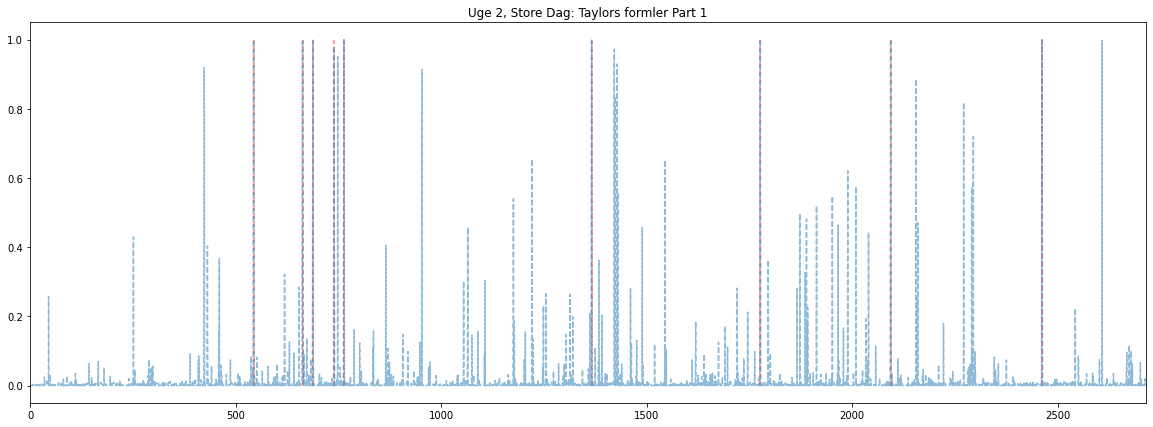

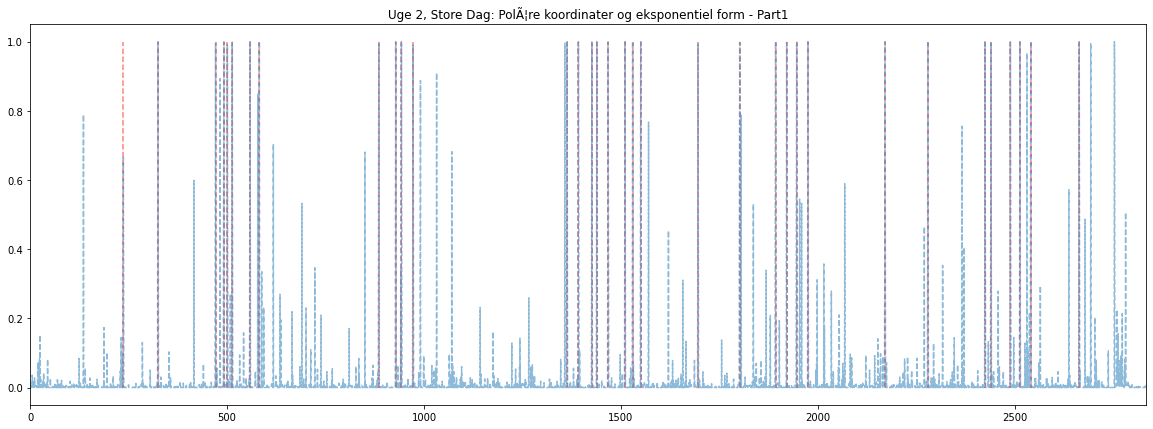

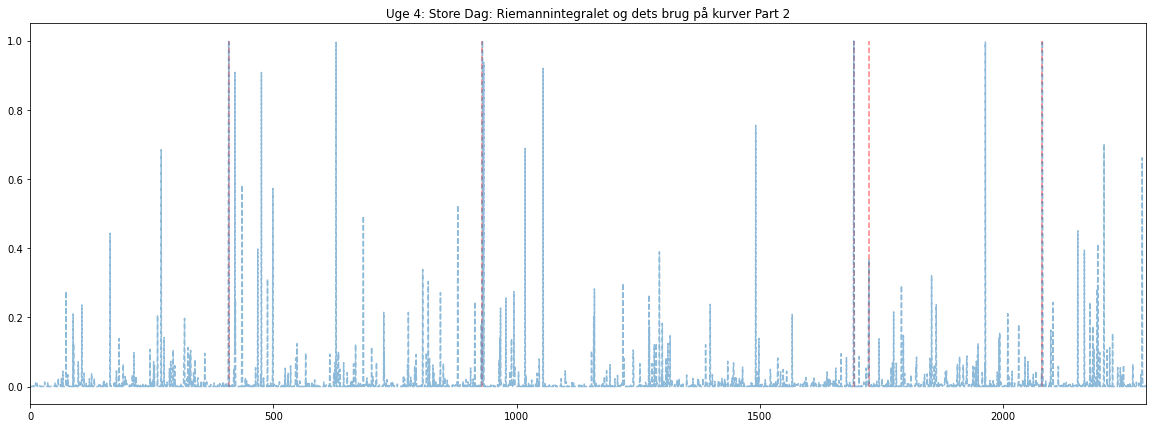

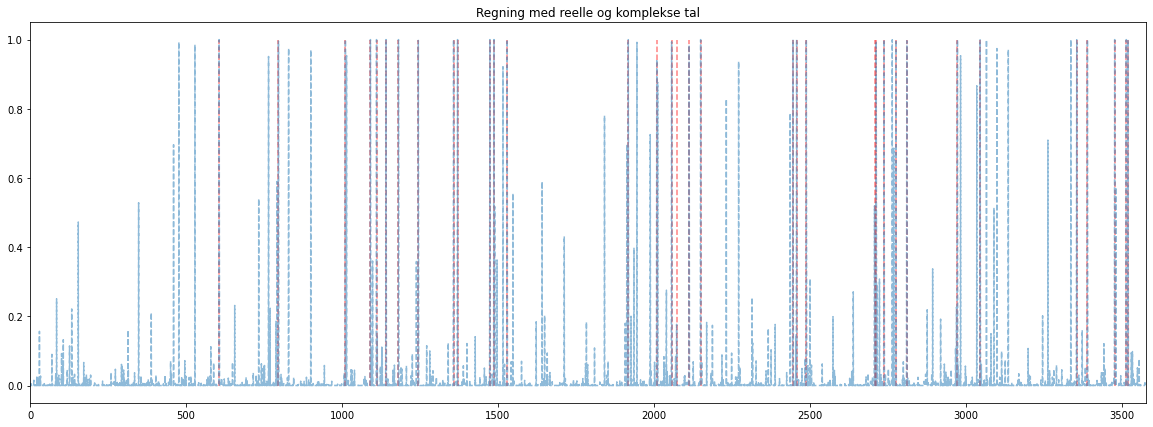

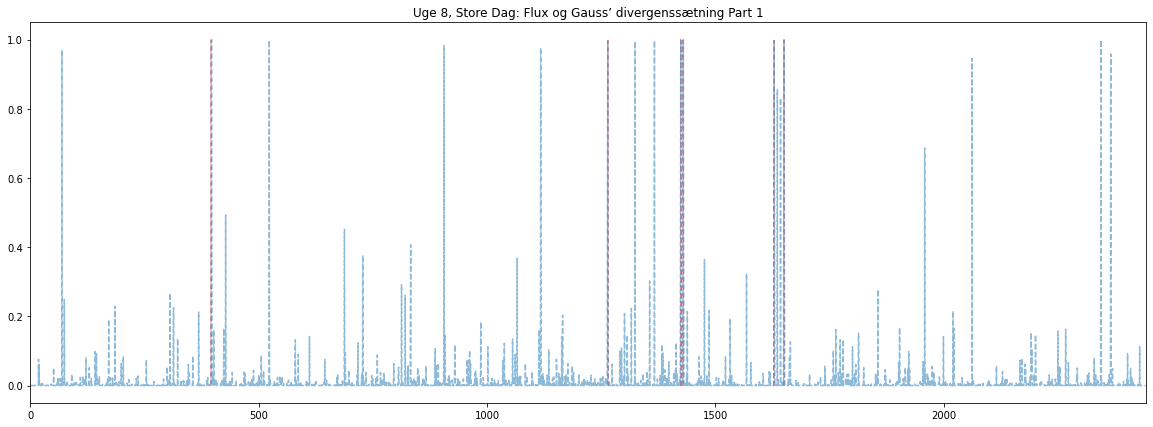

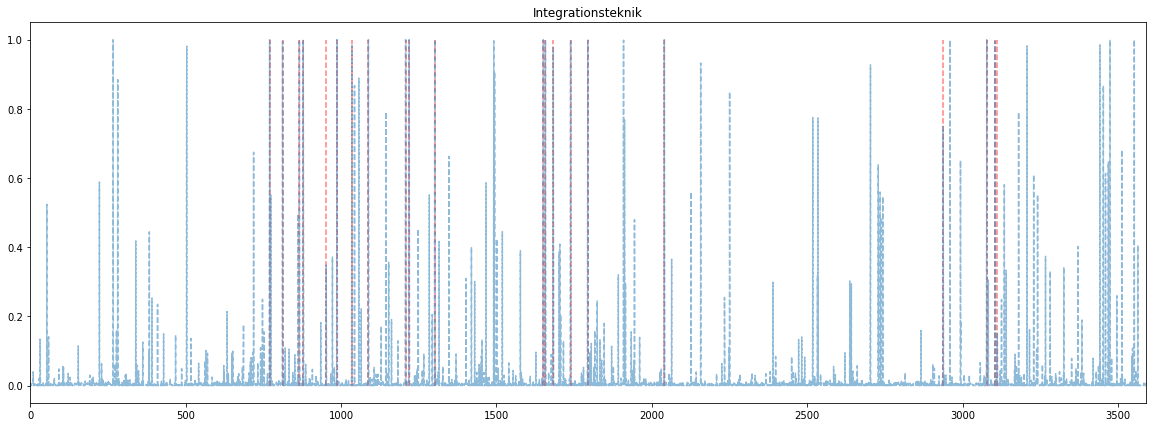

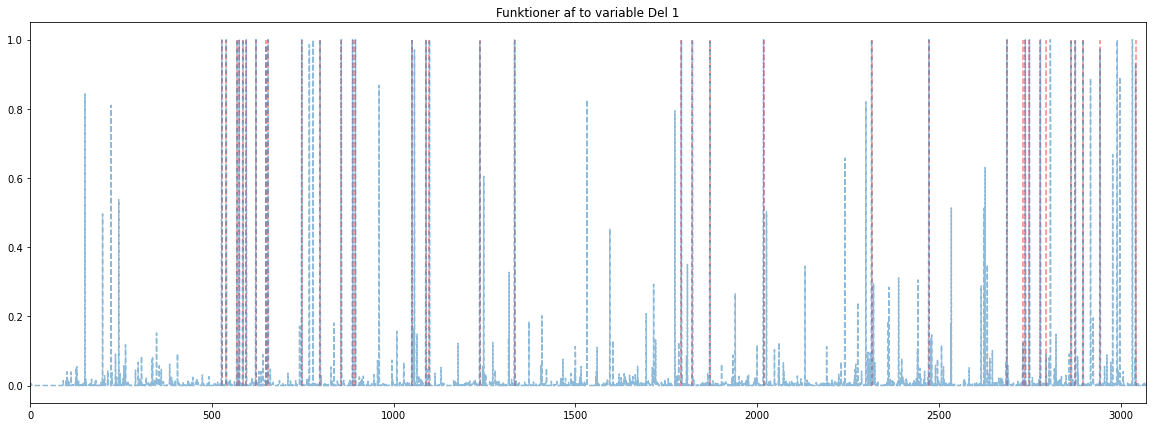

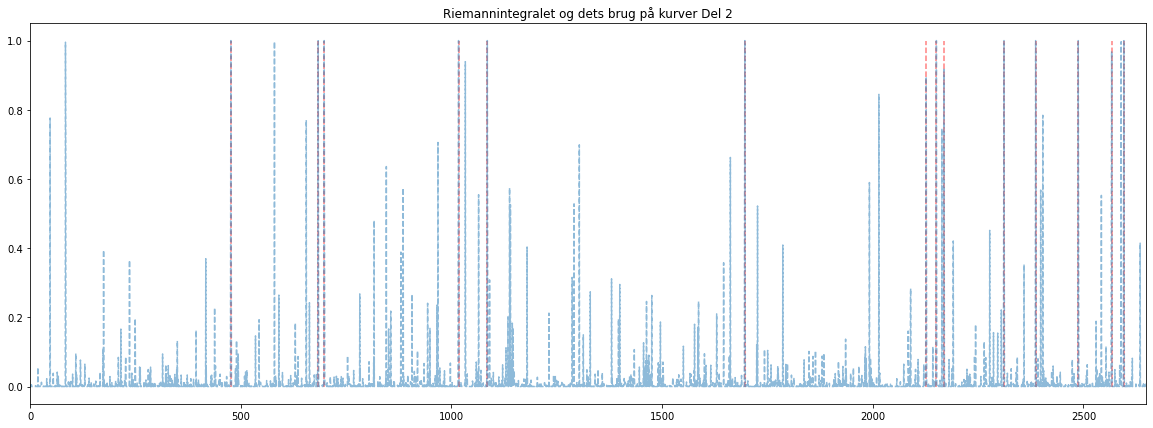

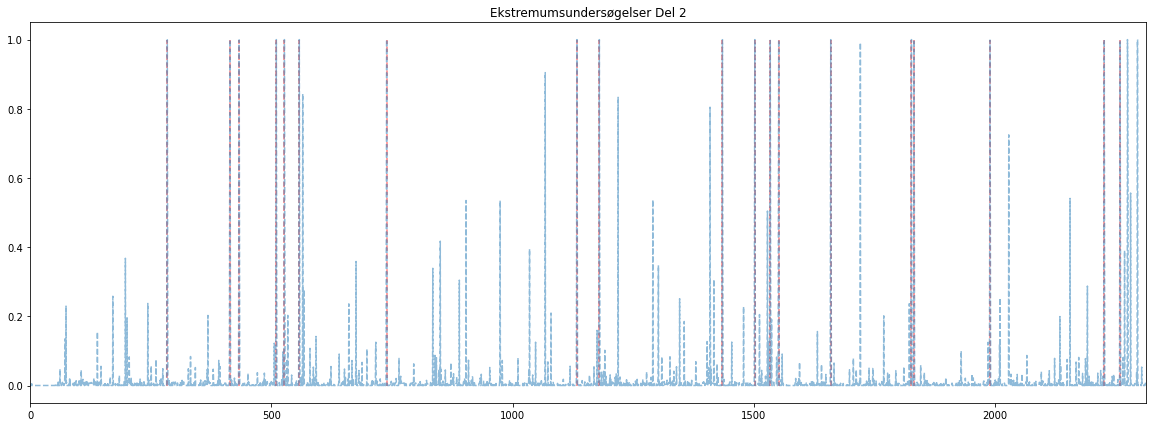

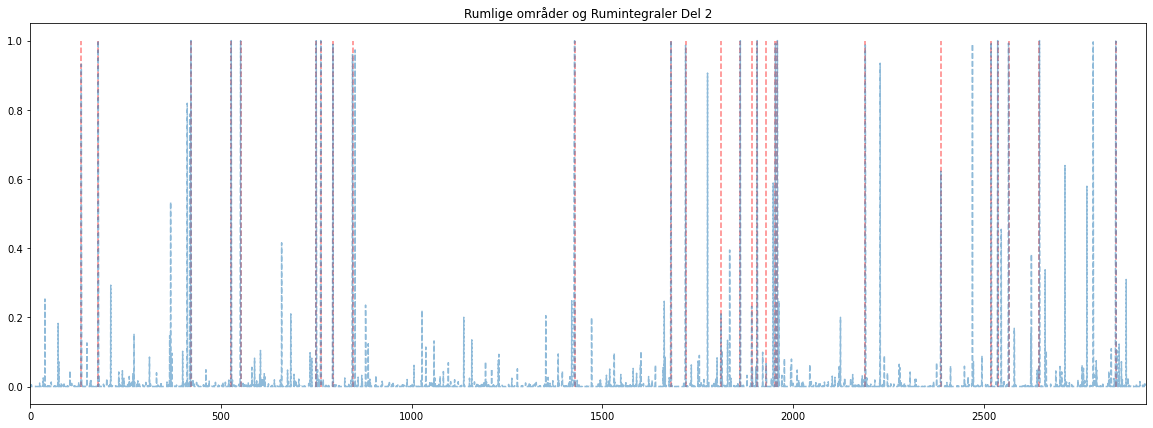

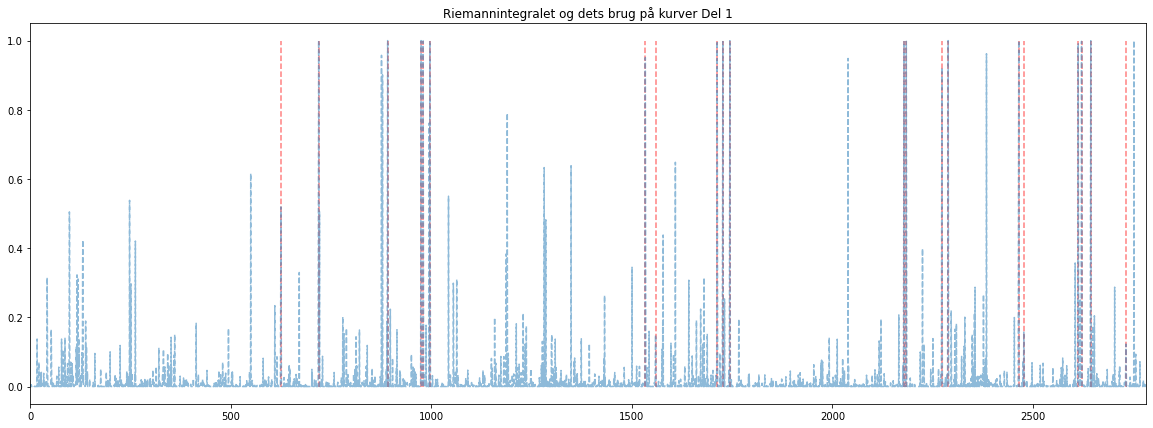

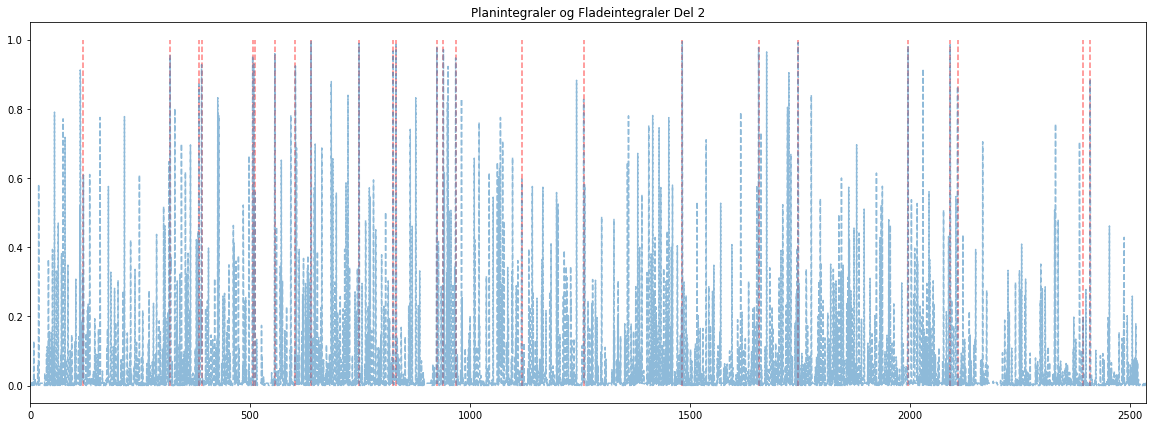

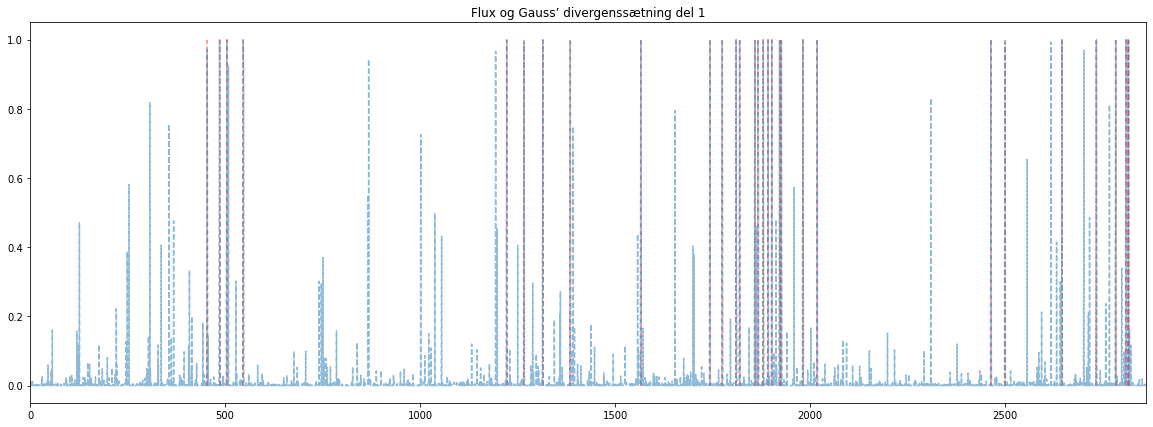

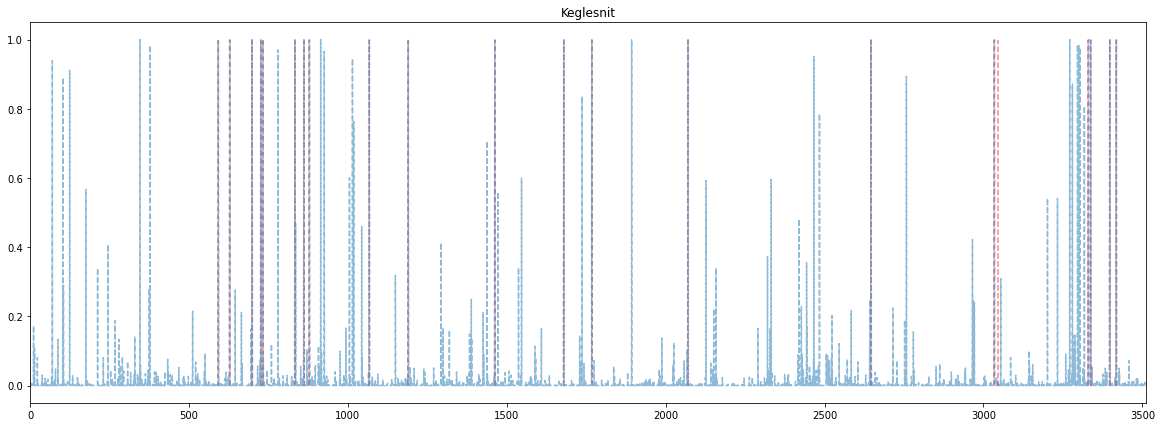

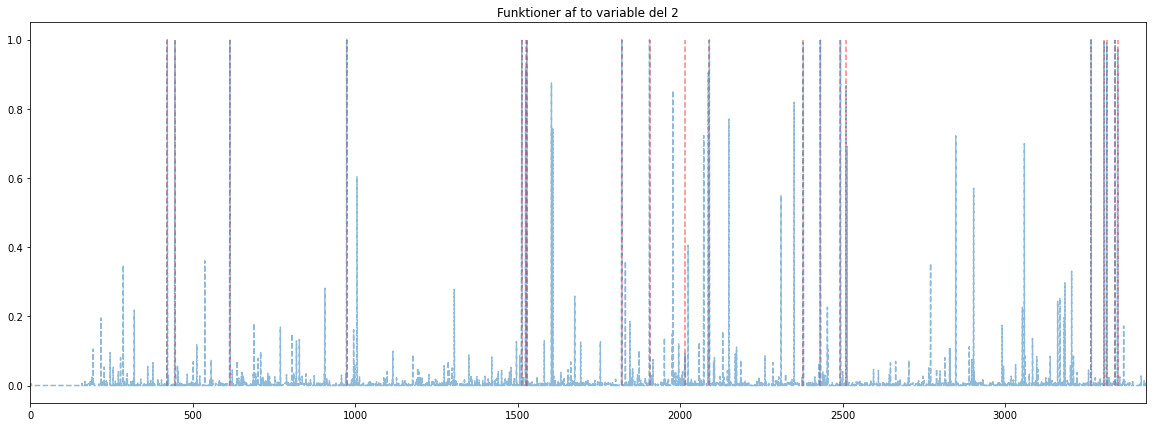

In [54]:
_, val, _ = wf.get_splits()

for lecID in np.unique(ID):
    mask = ID==lecID

    lecp  = p[mask]
    lect1 = t1[mask]
    lect2 = t2[mask]

    eval_t = (lect1 + lect2)/2.

    lecp   = lecp[eval_t.argsort()]
    eval_t = eval_t[eval_t.argsort()]

    subset = val.loc[val['ID'] == lecID]
    ground_truth_t = subset[['t1', 't2']].mean(axis=1).to_numpy()

    path = os.path.join('/work3/s164419/01005WakeWordData/lectures', f'{lecID}.wav')

    plt.figure(figsize=(20,7))
    plt.title(subset['title'].iloc[0])
    plt.plot(eval_t, lecp, '--', alpha = 0.5)
    plt.vlines(ground_truth_t, ymin=0, ymax=1, linestyles='--', colors='r', alpha=0.5)

    plt.xlim(0, wf.lecture_durations()[lecID])
    plt.show()
